In [171]:
import os
import math
import rasterio as rio
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from pprint import pprint

---
## Read in dem/tiff data

In [126]:
dem = rio.open("../data/merged.tiff")
elevation = dem.read(1)
dem_lngs = np.array([dem.transform[2]], dtype=np.float64) + np.array([i*np.array([dem.transform[0]], dtype=np.float64) for i in range(dem.width)],dtype=np.float64).flatten()
dem_lats = np.array([dem.transform[5]], dtype=np.float64) + np.array([i*np.array([dem.transform[4]], dtype=np.float64) for i in range(dem.height)],dtype=np.float64).flatten()


In [127]:
print(elevation.shape)
print(dem.width, len(dem_lats), dem_lats[0],dem_lats[-1])
print(dem.height, len(dem_lngs), dem_lats[0],dem_lngs[-1])
print(dem.lnglat())
print(dem.nodata)
dem.transform


(2401, 2401)
2401 2401 37.000416666666666 35.000416666666666
2401 2401 37.000416666666666 -83.00041666666667
(-83.99990999999746, 36.000081111108415)
None


Affine(0.0008333333333333334, 0.0, -85.00041666666667,
       0.0, -0.0008333333333333334, 37.000416666666666)

In [11]:
dem.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 2401,
 'height': 2401,
 'count': 1,
 'crs': CRS.from_epsg(4267),
 'transform': Affine(0.0008333333333333334, 0.0, -85.00041666666667,
        0.0, -0.0008333333333333334, 37.000416666666666)}

---
## Read in netcdf data

In [131]:
ds = nc.Dataset('../LFBB.nc')
nc_lats = ds['latitude'][:].astype(np.float64)
nc_lngs = ds['longitude'][:].astype(np.float64)


In [156]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(17), latitude(14), time(29952)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 dem(longitude, longitude), float32 bdy(longitude, latitude), float32 Fraction_of_reflected_sunlight(time, longitude, latitude), float32 Accumulated_Precipitation(time, longitude, latitude), float32 Fractional_Vegetation_Cover(time, longitude, latitude), float32 Downward_Longwave_Radiation_Flux_at_Surface(time, longitude, latitude), float32 Downward_Shortwave_Radiation_Flux_at_Surface(time, longitude, latitude), float32 Fraction_of_Photosynthetically_Active_Radiation(time, longitude, latitude), float32 International_Geosphere-Biosphere_Programme_Land_Cover_Classification(time, longitude, latitude), float32 Leaf_Area_Index(time, longitude, latitude), float32 Air_Pressure_at_Surface(time, longitude, latitude), float32 Specific_Humidity_2_m

In [133]:
print(nc_lats)
print(nc_lngs)


<class 'numpy.ma.core.MaskedArray'>
[-83.97676849 -83.95028687 -83.9238205  -83.8973465  -83.87088013
 -83.84441376 -83.81793976 -83.79147339 -83.76499939 -83.73853302
 -83.71205902 -83.68559265 -83.65911865 -83.63263702 -83.60617828
 -83.57969666 -83.55323792]


---
## Get indices

In [14]:
ds['Emissivity'][0,:].shape

(17, 14)

In [134]:
nc_0_lat, nc_n_lat = nc_lats[0], nc_lats[-1]
nc_0_lng, nc_n_lng = nc_lngs[0], nc_lngs[-1]
dem_0_lat, dem_n_lat = dem_lats[0], dem_lats[-1]
dem_0_lng, dem_n_lng = dem_lngs[0], dem_lngs[-1]

print(f'NETCDF: ')
print(f'    i=0 lat:{nc_0_lat}')
print(f'    i=n lat:{nc_n_lat}')
print(f'    i=0 lng:{nc_0_lng}')
print(f'    i=n lng:{nc_n_lng}')

print(f'DEM: ')
print(f'    i=0 lat:{dem_0_lat}')
print(f'    i=n lat:{dem_n_lat}')
print(f'    i=0 lng:{dem_0_lng}')
print(f'    i=n lng:{dem_n_lng}')

NETCDF: 
    i=0 lat:35.88676071166992
    i=n lat:35.54264831542969
    i=0 lng:-83.97676849365234
    i=n lng:-83.55323791503906
DEM: 
    i=0 lat:37.000416666666666
    i=n lat:35.000416666666666
    i=0 lng:-85.00041666666667
    i=n lng:-83.00041666666667


In [135]:
# find inidices that contain the nc coordinates

# latitudes - decrease as i->n
min_lat_idx, max_lat_idx = -1, -1
for i in range(len(dem_lats)):
    lat = dem_lats[i]
    if lat < nc_0_lat  and min_lat_idx == -1: # correct
        min_lat_idx = i
    if lat > nc_n_lat: # correct
        max_lat_idx = i
print(min_lat_idx, dem_lats[min_lat_idx]) # correct
print(max_lat_idx, dem_lats[max_lat_idx]) # correct

# longitudes - increase as i->n
min_lng_idx, max_lng_idx = -1,-1
for i in range(len(dem_lngs)):
    lng = dem_lngs[i]
    if lng < nc_n_lng: # correct
        max_lng_idx = i
    if lng > nc_0_lng and min_lng_idx == -1: # correct
        min_lng_idx = i

print(min_lng_idx, dem_lngs[min_lng_idx]) # correct
print(max_lng_idx, dem_lngs[max_lng_idx]) # correct

1337 35.88625
1749 35.54291666666666
1229 -83.97625
1736 -83.55375


---
# min max scale

In [136]:
def min_max_scale(data):
    min_v, max_v = np.inf, -np.inf
    for i in range(len(data)):
        for j in range(len(data[i])):
            v = data[i][j]
            if v < min_v:
                min_v = v
            elif v > max_v:
                max_v = v
    for i in range(len(data)):
        for j in range(len(data[i])):
            v = data[i][j]
            data[i][j] = (v-min_v)/(max_v-min_v)
    return data


---
# interpolation

In [137]:
def blerp(q11,q12,q21,q22,x1,x2,y1,y2,x,y):
    x2x1 = x2 - x1
    y2y1 = y2 - y1
    x2x = x2 - x
    y2y = y2 - y
    yy1 = y - y1
    xx1 = x - x1
    return 1 / (x2x1*  y2y1) * (
            q11 * x2x * y2y +
            q21 * xx1 * y2y +
            q12 * x2x * yy1 +
            q22 * xx1 * yy1
    )

In [178]:
max_lat_idx - min_lat_idx + 1

413

In [179]:
def interpolate(data):
    # data_new = np.zeros((len(dem_lats), len(dem_lngs)))
    data_new = np.zeros((max_lat_idx - min_lat_idx + 1, max_lng_idx - min_lng_idx + 1))
    nc_lat_idx = 0
    for dem_lat_idx in range(min_lat_idx,max_lat_idx+1):
    # for dem_lat_idx in range(min_lat_idx,max_lat_idx+1):
        dem_lat = dem_lats[dem_lat_idx]
        nc_lat, nc_lat_next = nc_lats[nc_lat_idx], nc_lats[nc_lat_idx+1]
        if dem_lat < nc_lat_next:
            nc_lat_idx += 1
            nc_lat, nc_lat_next = nc_lats[nc_lat_idx], nc_lats[nc_lat_idx+1]
        nc_lng_idx = 0
        for dem_lng_idx in range(min_lng_idx, max_lng_idx+1):
            dem_lng = dem_lngs[dem_lng_idx]
            nc_lng, nc_lng_next = nc_lngs[nc_lng_idx], nc_lngs[nc_lng_idx+1]
            if dem_lng > nc_lng_next:
                nc_lng_idx += 1
                nc_lng, nc_lng_next = nc_lngs[nc_lng_idx], nc_lngs[nc_lng_idx+1]

            data_new[dem_lat_idx-max_lat_idx, dem_lng_idx-max_lng_idx] = blerp(
                # data[nc_lng_idx][nc_lat_idx+1], # Q11 - bottom right value  # used if data is not transposed
                # data[nc_lng_idx+1][nc_lat_idx+1], # Q12 - top right value
                # data[nc_lng_idx][nc_lat_idx], # 21 - bottom left value
                # data[nc_lng_idx+1][nc_lat_idx], # Q22 - top left value Q
                data[nc_lat_idx+1][nc_lng_idx], # Q11 - bottom right value
                data[nc_lat_idx+1][nc_lng_idx+1], # Q12 - top right value
                data[nc_lat_idx][nc_lng_idx], # 21 - bottom left value
                data[nc_lat_idx][nc_lng_idx+1], # Q22 - top left value Q

                nc_lat_next, # x1 - left x value
                nc_lat, # x2 - right x value

                nc_lng, # y1 - bottom y value
                nc_lng_next, # y2 - top y value

                dem_lat, # x - x interp value
                dem_lng,  # y - y interp value
            )
    return data_new


---
# Color bar


In [139]:
def cbar(v):
    return HSVtoRGB(v, 1, 1)

def HSVtoRGB(h,s,v):
    i = math.floor(h * 6)
    f = h * 6 - i
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    m = i % 6
    if m == 0:
        r,g,b = v,t,p
    elif m == 1:
        r,g,b = q,v,p
    elif m == 2:
        r,g,b = p,q,t
    elif m == 3:
        r,g,b = p,q,v
    elif m == 4:
        r,g,b = t,p,v
    else: # m == 5:
        r,g,b = v,p,q
    return [
        round(r*255),
        round(g*255),
        round(b*255),
    ]


---
# Putting it all together

In [226]:
from sklearn.preprocessing import MinMaxScaler

data = ds['Air_Pressure_at_Surface'][0, :].astype(np.float64)
data_scaled = min_max_scale(data.copy())
data_new = interpolate(data_scaled.T)


In [227]:
print(data)

[[984.67950439 985.28485107 984.74414062 984.32495117 983.90112305
  982.68786621 980.14587402 978.85174561 978.0993042  972.85974121
  968.32244873 972.68304443 972.97705078 967.92071533]
 [983.828125   985.30834961 984.59606934 983.88708496 982.24694824
  981.42193604 979.73828125 979.70404053 973.08984375 964.93029785
  968.08447266 954.79138184 955.54467773 946.03393555]
 [984.33544922 984.48748779 983.10595703 982.83374023 981.9987793
  980.8057251  980.49139404 980.00244141 963.28161621 949.09851074
  957.01922607 962.98950195 940.43945312 931.71099854]
 [980.91680908 979.61834717 982.05249023 984.4362793  983.78186035
  981.96362305 976.20141602 974.20031738 971.05438232 960.88751221
  958.59155273 958.47088623 944.06195068 910.85217285]
 [981.68572998 979.87365723 978.7835083  981.53466797 982.48474121
  981.7935791  979.22375488 970.75       967.56585693 959.85681152
  951.04931641 951.77227783 940.92919922 917.05407715]
 [982.22821045 980.12536621 979.43725586 980.6060791  98

In [228]:
print(data_scaled)

[[0.99521507 0.9998212  0.99570689 0.99251724 0.9892923  0.98006053
  0.96071831 0.95087118 0.9451458  0.90527755 0.87075292 0.90393305
  0.90617016 0.8676961 ]
 [0.98873685 1.         0.9945802  0.98918548 0.97670555 0.97042797
  0.95761691 0.95735636 0.90702841 0.84494178 0.86894215 0.76779396
  0.77352585 0.70115785]
 [0.99259712 0.993754   0.98324182 0.9811705  0.97481722 0.96573917
  0.9633474  0.95962692 0.83239683 0.72447645 0.7847458  0.83017411
  0.65858899 0.59217348]
 [0.96658442 0.95670432 0.97522591 0.99336435 0.98838482 0.97454971
  0.93070462 0.9154781  0.89154043 0.8141799  0.79670976 0.7957916
  0.68615286 0.43345701]
 [0.9724352  0.95864699 0.95035196 0.97128576 0.97851494 0.97325583
  0.95370183 0.88922436 0.86499596 0.80633722 0.73932028 0.74482135
  0.6623155  0.48064779]
 [0.97656298 0.96056227 0.95532638 0.96422005 0.97112785 0.95916111
  0.92903038 0.92988166 0.8589817  0.76303364 0.67197872 0.76417937
  0.70426854 0.52931915]
 [0.96519766 0.96200151 0.95479322 

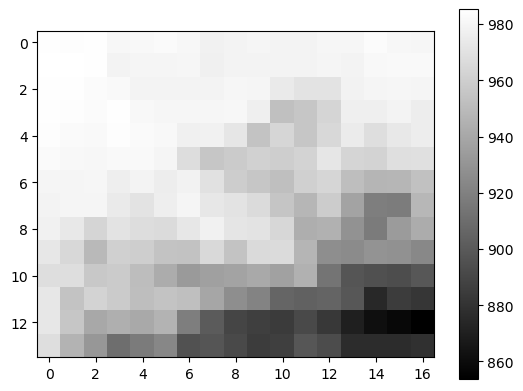

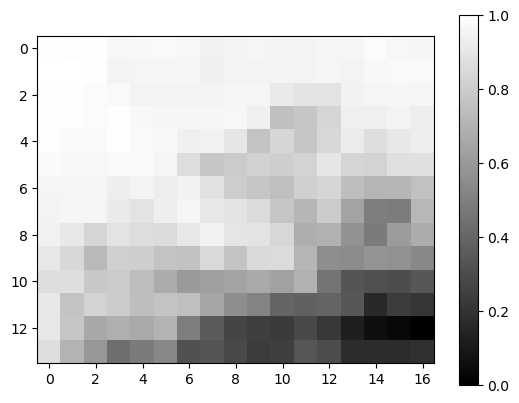

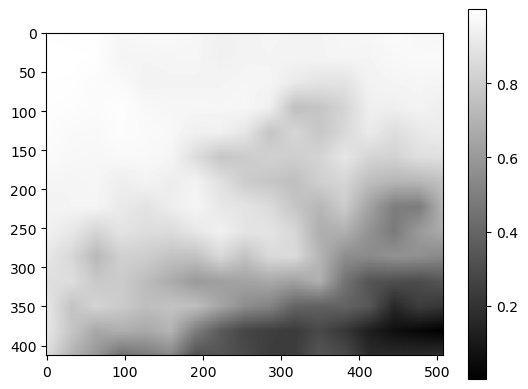

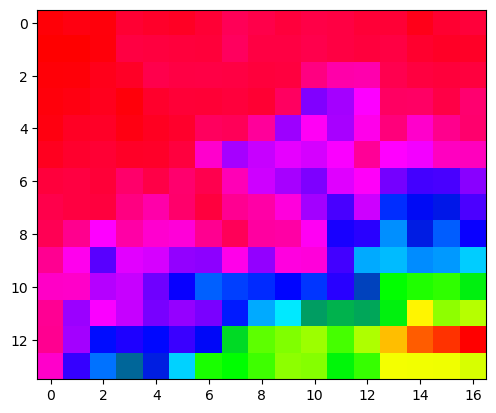

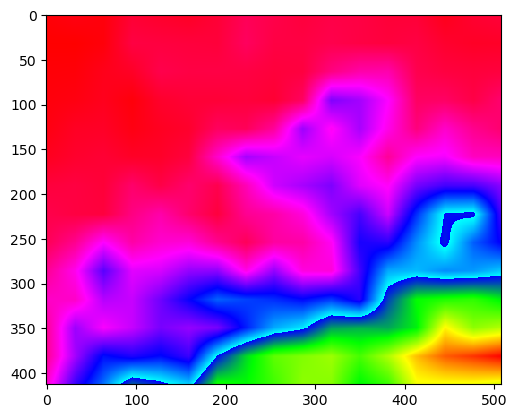

In [229]:
plt.imshow(data.T, cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(data_scaled.T, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(data_new, cmap='gray')
plt.colorbar()
plt.show()


e_c = np.zeros((data_scaled.shape[1],data_scaled.shape[0],3)).astype(int)
for i in range(len(data_scaled.T)):
    for j in range(len(data_scaled.T[i])):
        e_c[i,j] = cbar(data_scaled.T[i,j])
plt.imshow(e_c)
plt.show()

data_c = np.zeros((data_new.shape[0],data_new.shape[1],3)).astype(int)
for i in range(len(data_new)):
    for j in range(len(data_new[i])):
        data_c[i,j] = cbar(data_new[i,j])

plt.imshow(data_c)
plt.show()
# plt.imshow(data_c[ min_lat_idx:max_lat_idx+1, min_lng_idx:max_lng_idx+1])
# plt.show()



# create new dem file

In [142]:
new_dem_lngs = dem_lngs[min_lng_idx:max_lng_idx+1]
new_dem_lats = dem_lats[min_lat_idx:max_lat_idx+1]
new_dem_elevation = elevation[min_lat_idx:max_lat_idx+1, min_lng_idx:max_lng_idx+1]


In [148]:
print(new_dem_lats[:3], new_dem_lats[-3:])
print(new_dem_lngs[:3], new_dem_lngs[-3:])
print(len(new_dem_lats),len(new_dem_lngs))
print(new_dem_elevation.shape)
print(new_dem_lats[0] + (413)*dem.meta['transform'][4])
print(new_dem_lngs[0] + (508)*dem.meta['transform'][0])


[35.88625    35.88541667 35.88458333] [35.54458333 35.54375    35.54291667]
[-83.97625    -83.97541667 -83.97458333] [-83.55541667 -83.55458333 -83.55375   ]
413 508
(413, 508)
35.54208333333333
-83.55291666666666


In [145]:
out_meta = dem.meta.copy()
out_transform = rio.transform.Affine(
    dem.meta['transform'][0], dem.meta['transform'][1], new_dem_lngs[0],
    dem.meta['transform'][3], dem.meta['transform'][4], new_dem_lats[0],
)
print(out_meta)
out_meta.update({'driver':'GTiff',
                 'width': len(new_dem_lngs),
                 'height': len(new_dem_lats),
                 'dtype':'int16',
                 'transform':out_transform})
print(out_meta)
with rio.open(os.path.join('..', 'ndvi.tiff'), 'w', **out_meta) as dst:
    dst.write_band(1, new_dem_elevation.astype(rio.int16))

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 2401, 'height': 2401, 'count': 1, 'crs': CRS.from_epsg(4267), 'transform': Affine(0.0008333333333333334, 0.0, -85.00041666666667,
       0.0, -0.0008333333333333334, 37.000416666666666)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 508, 'height': 413, 'count': 1, 'crs': CRS.from_epsg(4267), 'transform': Affine(0.0008333333333333334, 0.0, -83.97625,
       0.0, -0.0008333333333333334, 35.88625)}


In [94]:
dem.meta['transform']


Affine(0.0008333333333333334, 0.0, -85.00041666666667,
       0.0, -0.0008333333333333334, 37.000416666666666)

In [39]:
new_dem_lngs[0]

-83.97666666666666

In [40]:
out_transform[2]

-85.00041666666667

In [49]:
dem.transform

| 0.00, 0.00,-85.00|
| 0.00,-0.00, 37.00|
| 0.00, 0.00, 1.00|


In [44]:
out_transform

Affine(0.0008333333333333334, 0.0, -83.97666666666666,
       0.0, -0.0008333333333333334, 35.88666666666666)

In [57]:
print(len(new_dem_lngs), len(new_dem_lats))
new_dem_elevation.shape

509 413


(413, 509)

In [58]:
out_meta['crs']

CRS.from_epsg(4267)

In [71]:
35.886666666666666666 + -0.000833333333*412

35.54333333347066

In [76]:
35.886666666666666666 + -0.000833333333*508

35.46333333350266

In [32]:
print(new_dem_lats[0], new_dem_lats[-1])
print(new_dem_lngs[0], new_dem_lngs[-1])


35.88666666666666 35.54333333333334
-83.97666666666666 -83.55333333333333


In [79]:
print(dem_lngs)

[-85.0, -84.99916666666667, -84.99833333333333, -84.9975, -84.99666666666667, -84.99583333333334, -84.995, -84.99416666666667, -84.99333333333334, -84.9925, -84.99166666666666, -84.99083333333333, -84.99, -84.98916666666666, -84.98833333333333, -84.9875, -84.98666666666666, -84.98583333333333, -84.985, -84.98416666666667, -84.98333333333333, -84.9825, -84.98166666666667, -84.98083333333334, -84.98, -84.97916666666667, -84.97833333333334, -84.9775, -84.97666666666667, -84.97583333333333, -84.975, -84.97416666666666, -84.97333333333333, -84.9725, -84.97166666666666, -84.97083333333333, -84.97, -84.96916666666667, -84.96833333333333, -84.9675, -84.96666666666667, -84.96583333333334, -84.965, -84.96416666666667, -84.96333333333334, -84.9625, -84.96166666666667, -84.96083333333333, -84.96, -84.95916666666666, -84.95833333333333, -84.9575, -84.95666666666666, -84.95583333333333, -84.955, -84.95416666666667, -84.95333333333333, -84.9525, -84.95166666666667, -84.95083333333334, -84.95, -84.949

In [149]:
t = rio.open("../ndvi.tiff")
t2 = t.read(1)

t_lats = [t.xy(i,0)[1] for i in range(t.height)]
t_lngs = [t.xy(0,i)[0] for i in range(t.width)]
print(t_lngs[0],t_lngs[-1], len(t_lngs))
print(t_lats[0],t_lats[-1], len(t_lats))
print(t.xy(0,0))
print(t2.shape)
print(t.width)
print(t.height)
print(t.lnglat())
print(t_lats[0],t_lats[1], t_lats[-2], t_lats[-1])
print(t_lngs[0], t_lngs[1], t_lngs[-2], t_lngs[-1])


-83.97583333333333 -83.55333333333333 508
35.88583333333333 35.5425 413
(-83.97583333333333, 35.88583333333333)
(413, 508)
508
413
(-83.76447851575287, 35.71425407562362)
35.88583333333333 35.885 35.54333333333333 35.5425
-83.97583333333333 -83.975 -83.55416666666666 -83.55333333333333


In [93]:
print(new_dem_lngs[0],new_dem_lngs[-1],len(new_dem_lngs))
print(new_dem_lats[0],new_dem_lats[-1],len(new_dem_lats))


-83.97666666666666 -83.55333333333333 509
35.88666666666666 35.54333333333334 413


In [150]:
t2.shape

(413, 508)

In [155]:
t2[-2:,-2:]

array([[1111, 1104],
       [1094, 1081]], dtype=int16)

In [154]:
new_dem_elevation[-2:,-2:]

array([[1111, 1104],
       [1094, 1081]], dtype=int16)

In [216]:
np.divide((10 - 15), (15 - 5))


-0.5

---
# new netcdf file

In [157]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(17), latitude(14), time(29952)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 dem(longitude, longitude), float32 bdy(longitude, latitude), float32 Fraction_of_reflected_sunlight(time, longitude, latitude), float32 Accumulated_Precipitation(time, longitude, latitude), float32 Fractional_Vegetation_Cover(time, longitude, latitude), float32 Downward_Longwave_Radiation_Flux_at_Surface(time, longitude, latitude), float32 Downward_Shortwave_Radiation_Flux_at_Surface(time, longitude, latitude), float32 Fraction_of_Photosynthetically_Active_Radiation(time, longitude, latitude), float32 International_Geosphere-Biosphere_Programme_Land_Cover_Classification(time, longitude, latitude), float32 Leaf_Area_Index(time, longitude, latitude), float32 Air_Pressure_at_Surface(time, longitude, latitude), float32 Specific_Humidity_2_m

In [209]:
ds.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
 unlimited dimensions: 
 current shape = (17,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
 unlimited dimensions: 
 current shape = (14,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'dem': <class 'netCDF4._netCDF4.Variable'>
 float32 dem(longitude, longitude)
 unlimited dimensions: 
 current shape = (17, 17)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'bdy': <class 'netCDF4._netCDF4.Variable'>
 float32 bdy(longitude, latitude)
 unlimited dimensions: 
 current shape = (17, 14)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'Fraction_of_reflected_sunlight': <class 'netCDF4._netCDF4.Variable'>
 float32 Fraction_of_reflected_sunlight(time, longitude, latitude)
     units: (Percentage)
 unlimited dimensions: tim

In [213]:
ds.dimensions['time'].size

29952

In [203]:
for k in ds.variables.keys():
    if k not in ['longitude', 'latitude']:
        if 'units' in dir(ds[k]):
            print(ds[k].units)


(Percentage)
(mm/hr)_at_surface
(decimal_from_0_to_1)
(W/m2)
(W/m2)
(decimal_from_0_to_1)
(1_to_17_with_each_number_corresponding_to_a_categorical_class)
(m2/m2)
(millibars)
(kg/kg)
(Kelvin)
(m/s)


In [215]:
ds['Leaf_Area_Index'][29951]

masked_array(
  data=[[0.49280798, 0.42714283, 0.33553907, 0.36116484, 0.34513804,
         0.2637784 , 0.27214563, 0.5180584 , 0.59304506, 0.651376  ,
         0.6479363 , 0.69388133, 0.8540828 , 0.7389563 ],
        [0.52881926, 0.42576155, 0.43181196, 0.5184701 , 0.48145387,
         0.3426717 , 0.44866768, 0.615538  , 0.6324631 , 0.6331427 ,
         0.6047788 , 0.7913399 , 0.81190443, 0.77461874],
        [0.5742944 , 0.5919842 , 0.66818273, 0.6077618 , 0.60524327,
         0.46125573, 0.5718785 , 0.64990586, 0.6216567 , 0.5720708 ,
         0.67252314, 0.8097012 , 0.76272184, 0.6933485 ],
        [0.63429123, 0.657112  , 0.6805617 , 0.6892891 , 0.62283814,
         0.5608554 , 0.5890875 , 0.6149074 , 0.5847626 , 0.6044526 ,
         0.7414453 , 0.8771952 , 0.77792287, 0.67481077],
        [0.56026304, 0.6661099 , 0.69537944, 0.708635  , 0.6438682 ,
         0.50528544, 0.5420506 , 0.58225626, 0.6766097 , 0.68018216,
         0.7099358 , 0.8602889 , 0.7825433 , 0.74206156],
      

In [208]:
# open dataset
new_ds = nc.Dataset('test.nc', 'w', format="NETCDF4")

# create dimensions
new_ds_dim_lat = new_ds.createDimension("longitude", size=len(new_dem_lngs))
new_ds_dim_lon = new_ds.createDimension("latitude", size=len(new_dem_lats))
new_ds_dim_time = new_ds.createDimension("time", size=None)

# create lat lon variables
new_ds_var_lon = new_ds.createVariable('longitude', 'f4', ('longitude',))
new_ds_var_lat = new_ds.createVariable('latitude', 'f4', ('latitude',))
new_ds_var_lon[:] = new_dem_lngs
new_ds_var_lat[:] = new_dem_lats

# create other variables
for k in ds.variables.keys():
    if k not in ['longitude', 'latitude']:
        new_ds_var = new_ds.createVariable(k, 'f4', ('time', 'latitude', 'longitude',))
        if 'units' in dir(ds[k]):
            new_ds_var.units = ds[k].units
# for t in range(0,100):
#     data = ds['Air_Pressure_at_Surface'][0, :].astype(np.float64)
#     data_scaled = min_max_scale(data)
#     data_new = interpolate(data_scaled.T)
#     new_ds_var[t,:] = data_new

# debug print
print(new_ds)
pprint(new_ds.dimensions)
pprint(new_ds.variables)
# pprint(new_ds['longitude'][:])
# close dataset
new_ds.close()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): longitude(508), latitude(413), time(0)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 dem(time, latitude, longitude), float32 bdy(time, latitude, longitude), float32 Fraction_of_reflected_sunlight(time, latitude, longitude), float32 Accumulated_Precipitation(time, latitude, longitude), float32 Fractional_Vegetation_Cover(time, latitude, longitude), float32 Downward_Longwave_Radiation_Flux_at_Surface(time, latitude, longitude), float32 Downward_Shortwave_Radiation_Flux_at_Surface(time, latitude, longitude), float32 Fraction_of_Photosynthetically_Active_Radiation(time, latitude, longitude), float32 International_Geosphere-Biosphere_Programme_Land_Cover_Classification(time, latitude, longitude), float32 Leaf_Area_Index(time, latitude, longitude), float32 Air_Pressure_at_Surface(time, latitude, longitude), float32 Specific_Humidity_2_m_a

In [206]:
new_ds.close()


In [168]:
from pprint import pprint


In [186]:
data_new.shape

(413, 508)